# Simulación, Monte Carlo

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [2]:
# plotting libraries

# for inline plots in jupyter
if True:
    %matplotlib inline
else:
    %matplotlib notebook
    
    
# import matplotlib
import matplotlib.pyplot as plt

#import numpy
import numpy as np

#import scipy.stats
import scipy.stats

# import integrate
import scipy.integrate as integrate


# for latex equations
from IPython.display import Math, Latex

# for displaying images
from IPython.core.display import Image

import seaborn as sns

# settings for seaborn plotting style
#sns.set(color_codes=True)

# settings for seaborn plot sizes
#sns.set(rc={'figure.figsize':(5,5)})

################## Funciones del modulo ############################################
#(A) Por areas

def integral_mc (rec_x, rec_y, N, f) :
    """Return the MC integration """
    mc_x = np.random.uniform(min(rec_x), max(rec_x), N)
    mc_y = np.random.uniform(min(rec_y), max(rec_y), N)
    
    points_under = [True if y <= f(x) else False 
                for x, y in zip (mc_x, mc_y)  ]
    int_mc = (max(rec_x) - min(rec_x)) * (max(rec_y) - min(rec_y)) / N * sum(points_under)  
    
    return int_mc
 

def simula_integral_mc (nSimula, rec_x, rec_y, N, f) :
    """Do nSimula simulations MC integration"""
    simul = np.empty (nSimula)    
    for i in np.arange (nSimula):
        simul[i] =  integral_mc (rec_x, rec_y, N, f)
    
    return simul


#(B)


def resultados (x, y, n, alpha) :
    z_alpha = scipy.stats.norm.ppf(1 - (alpha / 2) )    
    size = np.arange (start = 1, stop = n+1,  step=1)
    
    # media muestral
    media = np.cumsum (y) / size
    
    # Varianza muestral, s2
    media2 = media * media
    y2 = y * y
    s2 = np.cumsum (y2) / size - media2
    
    # varianza estimador
    sigma2 = s2 /  size
    
    #intervalo de confianza
    sigma = np.sqrt(sigma2)
    ci_inf = media - z_alpha * sigma
    ci_sup = media + z_alpha * sigma 
    
    resul = {'size':size, 'media' : media, 's2': s2, 'sigma2': sigma2, 
             'ci_inf': ci_inf, 'ci_sup':ci_sup}
    
    return resul


def resultados_old (x, y, n, alpha) :
    '''La única diferencia con la función resultados es la forma en calcular
    la varianza. Ambas versiones son correctas.'''
    z_alpha = scipy.stats.norm.ppf(1 - (alpha / 2) )    
    size = np.arange (start = 1, stop = n+1,  step=1)
    
    # media muestral
    media = np.cumsum (y) / size
    
    # Varianza muestral, s2
    s2 = (y - media) * (y - media)
    s2[0] = 0.
    s2[1:] = np.cumsum (s2)[1:] /  size[0:-1]
    
    # varianza estimador
    sigma2 = s2 /  size
    
    #intervalo de confianza
    sigma = np.sqrt(sigma2)
    ci_inf = media - z_alpha * sigma
    ci_sup = media + z_alpha * sigma 
    
    resul = {'size':size, 'media' : media, 's2': s2, 'sigma2': sigma2, 
             'ci_inf': ci_inf, 'ci_sup':ci_sup}
    
    return resul




## Introducción

**Resumen:**

En este capítulo presentamos varios algoritmos de Monte Carlo para estimación de integrales multidimensionales. Veremos los algoritmos de aceptación / rechazo y los algoritmos basados en medias. Analizaremos el error en la estimación a través de la varianza del estimador y presentaremos algunas técnicas para reducir su varianza sin aumentar el tamaño de la muestra (por e.g., el muestreo por importancia y el uso de variables antitéticas).

La evaluación de integrales de elevada dimensión por métodos de Monte Carlo es un campo importante, con un amplio espectro de aplicaciones. Aparecen de forma natural en mecánica estadística, economía financiera o el aprendizaje automático. Por otra parte las tećnicas que se dscriben en ete capítulo trascienden del campo de la integración, se aplican en multitud de problemas de simulación por Monte Carlo. 

**Conclusiones**

* Todos los algoritmos de integración de Monte Carlo realizarán una estimación puntual de la integral utilizando muestras de tamaño $n$ finito, $n \rightarrow \infty$.
* El error cometido en la estimación de la integral será proporcional a la varianza del estimador. En los algoritmos de Monte Carlo la varianza del estimador se comporta como $\sigma^2 / n$.
* A diferencia de los algoritmos de integración numérica, en los algoritmos de Monte Carlo la varianza no depende de la dimensión $d$ del problema. Por ejemplo, en los algoritmos de integración numérica que utilizan la regla trapezoidal $O( N^{-2/d})$. Esto hace que los algoritmos de Monte Carlo sean particularmente útiles en problemas de integración de alta dimensionalidad.
* Se presentan dos técnicas diferentes para reducir la varianza del estimador sin necesidad de aumentar el tamaño de la muestra: el muestreo por importancia (I.S) y el uso de variables antitéticas.
* En I.S la muestra que se utiliza para evaluar el estimador se selecciona de forma que esta sea mayoritaria en aquellos puntos con una mayor contribución al valor del estimador. 
* El muestreo por importancia permite, además, estimar del valor esperado de una transformación $h(X)$ de una v.a $X$ utilizando una muestra de otra distribución.  
* En el método de las variables antitéticas se utiliza una combinación lineal de estimadores cuyas muestras se hallan negatiavemente correlacionadas. 

**Requisitos:**

* Para entender esta lectura es necesario conocer y comprender los conceptos de variable aleatoria, p.d.f, c.d.f y teorema central del límite vistos en el Tema 1.

* *Muy importante*:
    No confundir la varianza del estimador $\left( \frac{\sigma^2}{n } \right)$, la varianza de la variable aleatoria que se emplea en el estimador ($\sigma^2)$ y la varianza de la muestra $(s^2)$.

##  Algoritmo aceptación / rechazo:


Supongamos que $g(x)$ es una función no-negativa de la que se desa hallar su área 
$A_D \equiv I = \int_{a}^{b} g(x) \,  dx$ . Definnamos la región rectangular que la encierra
$
R \doteq [a, b] \, \mathsf{x} \, [0, d]
$
donde $d$ es mayor o igual al valor máximo de la función $g(x)$ en el intervalo $(a,b)$,
$d \geq \max_ { x \in (a,b)} g(x) $. El área del rectángulo es $A_R = (b-a) \ d$ 

**Algoritmo**

El siguiente algoritmo produce una estimación $\widehat{A}_D$ del área buscada $A_D$ utilizando el método de aceptación y rechazo: 


*Descripción:*

* Generar una muestra de tamaño $n$ perteneciente a una distribución uniforme en el intervalo $[a, b]$, $ U \sim \mathcal{U}(a,\, b)$
* Generar una segunda muestra de tamaño $n$  extraída de una distribución uniforme  en el intervalo $[0, d]$, $ V \sim \mathcal{U}(0,\, d)$
* Con ambas muestras formar un conjunto de $n$ puntos aleatorios en la región rectangular $R \in \mathbb{R}^2$:
  $$
  ((u_i, v_i) \rightarrow (x_i, y_i) )_{i=0...n}
  $$
* Evaluar si cada uno de los puntos pertenece a la región $D$: si pertenece a dicha región se acepta, se le asigna valor 1, y sino se rechaza y se le asigna 0. Sea $S_n$ el ratio del total de puntos aceptados y de los puntos generados. 

* La magnitud $\widehat{A}_D =  S_n d \, (b-a) $ es una estimación del área $A_D$ y, por tanto, una estimación de la integral $I$ buscada.

* La Varianza $\text{Var} \left[S_n \right]$ es una medida del error del estimador $S_n$

*Pseudicódigo:*

1. **sample:** $u_1, u_2, \cdots , u_n \sim \mathcal{U}(a,b)$ **and** $v_1, v_2, \cdots , v_n \sim \mathcal{U}(0,d)$
2. **for** $i$  **in** $[1, 2,  \cdots ,n]$ :
     * **if** $f(u_i) \geq v_i$ : 
        * $X_i = 1$
     * **else** : 
        * $X_i = 0$
3. **return** ${S_n} = \frac{1}{n}\sum_{i=1}^{i=n} X_{i}$

Por tanto la estimación del área será:
$$
\widehat{I}  =   S_{n} A_R  = S_{n} \ d \ (b-a)
$$








*Discusión:*


* $X$  en una variable aleatoria que se distribuye según una distribución de Bernoulli (éxito / fallo)  $X \sim Bern(p)$, donde la probabilidad de éxito $p$ es, en esta caso,  la *probabilidad de aceptar el punto*, $p=\frac{A_D}{A_R}$. 

* El valor esperado y la varianza de una v.a  $X \sim Bern(p)$ son $\mu = E[X] = p$ y  $\sigma^2 = p \ (1-p)$ respectivamente.

* La media muestral $ S_n$ es un estimador puntual del valor esperado de $X$  y, por tanto, de la probabilidad $p$.

* La varianza de la media muestral $\text{Var}\left[ S_n \right] $ es una medida del error que cometemos en la estimación de $p$. Sabemos que  $\text{Var}\left[ S_n \right] = \frac{\sigma^2}{n}$.

* El intervalo de confianza de $S_n$ con una confianza de $1-\alpha$, (por ejemplo $\alpha=0.05$ el intervalo de confianza será del $95\%$) se define como
$$
\text{Error} \, = 2 \, z_{\alpha / 2} \frac{\sigma}{\sqrt{n}}
$$
donde $\sigma²$ es la varianza de $X\sim Bern(p)$ y $z_{\alpha / 2}$ el precentil correspondiente al valor de $\alpha$ elegido.
Para poder evaluar el error del estimador, ecuación (3), necesitamos conocer el valor de $\sigma^2$.
Al distribuirse $X$ según una distribución de Bernuolli, sabemos que la varianza será
$$
\sigma^2 = p \ (1-p)  =  \frac{A_D}{A_R}   \left( 1 - \frac{A_D}{A_R}  \right) 
$$

 El problema con la expresión anterior es que para evaluar el error de nuestra estimación deberíamos conocer el área $A_D$, que es precisamente lo que tratamos de estimar!!. 
 ¿Cómo podríamos estimar $\sigma^2$ para evaluar el error de $ S_n$ (3) sin recurrir al área $A_D$? Utilizaremos la varianza de la muestra $s^2(n)$ como estimador de $\sigma^2$
$$
s^2(n) = \frac{1}{n-1} \sum_{i=1}^n (X_i - S_n )^2
$$

> **Atención**: Hasta ahora hemos analizado la distribución de la v.a $S_n$ como estimador de $p$ (la probabilidad de que un punto caiga dentro de la región $D$), en concreto estudiamos su valor esperado y su varianza. Sin embargo, nosotros estábamos interesados en la estimación del área de la integral $\widehat I$. Sabemos que $S_n$ está relacionado con la estimación del área de la integral $\widehat I$ a través de la ecuación (2). ¿Cómo converge nuestra estimación al valor de $I$? Para ello debemos calcular la varianza de $\widehat I$
$$
\text{Var} \left[ \widehat I \right] =  A_R^2 \text{Var} \left[  S_{n}  \right]
$$

<div class="qst">
    
Supongamos la función: 
$$
g(x) = \sin( 2\pi x)^5 - 2 \cos \left( 3 \cos \left( \frac{x}{\pi} \right)^2 \right)^3
$$
y el intervalo $(a,b) = (0, 10)$. Estimar el área delimitada por la función $g(x)$ en el intervalo $(a,b)$. Evaluar (gráficamente) la precisión (incertidumbre) de la estimación.

</div>


Integracion: 12.255 Estimación: 12.226


<ipython-input-4-a0839c3995fa>:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_num = integrate.quad (g, min(rec_x), max(rec_x))


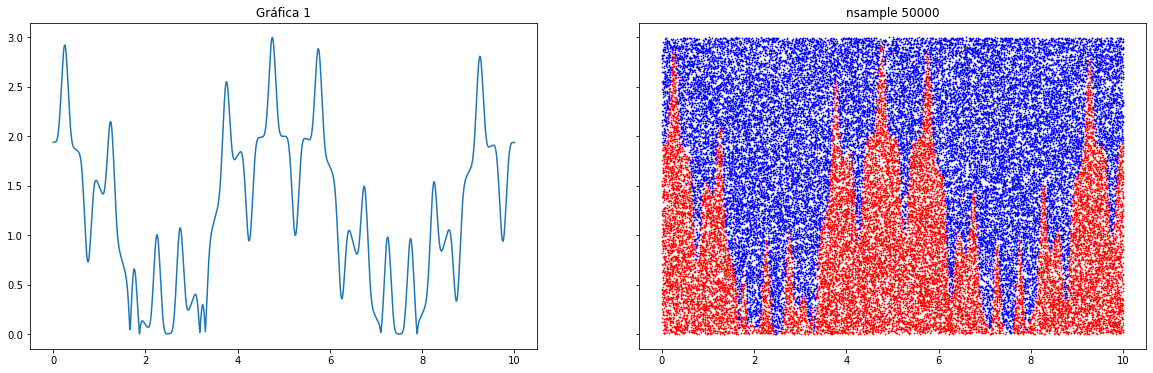

In [4]:
# Tamaño de las muestras X e Y
N = 50000

# Parámtros a,b y d que delimitan las regiones R y D
rec_x = (0, 10)
rec_y = (0, 3)

g = lambda x: np.abs(
    np.sin(2 * np.pi * x) ** 5 - 2 * np.cos(3 * np.cos(x / np.pi) ** 2) ** 3
)


# Set the random number seed so that results can be replicated
np.random.seed(123)

# Sample from uniform distributions
mc_x = np.random.uniform(min(rec_x), max(rec_x), N)
mc_y = np.random.uniform(min(rec_y), max(rec_y), N)

# Points under the curve (in region D)
points_under = [True if y <= g(x) else False for x, y in zip(mc_x, mc_y)]

# Area estimation
int_mc = (max(rec_x) - min(rec_x)) * (max(rec_y) - min(rec_y)) / N * sum(points_under)

# Integracion numérica
int_num = integrate.quad(g, min(rec_x), max(rec_x))

print(f"Integracion: {int_num[0]:.3f} Estimación: {int_mc:.3f}")

####### Plot figures
fig, ax = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

x = np.linspace(min(rec_x), max(rec_x), 1001)
ax[0].plot(x, g(x))
ax[0].set_title("Gráfica 1")

ax[1].scatter(mc_x[points_under], mc_y[points_under], c="r", s=0.5)

not_points_under = np.logical_not(points_under)
ax[1].scatter(mc_x[not_points_under], mc_y[not_points_under], c="b", s=0.5)
ax[1].set_title(f"nsample {N}")
plt.show()

In [6]:
# Realizamos las nSimula simulaciones independientes con muestras de tamaño 10000
N = 10000
simul = simula_integral_mc(nSimula=1000, rec_x=(0, 10), rec_y=(0, 3), N=N, f=g)
# Realizamos las nSimula simulaciones independientes con muestras de tamaño 10000
N2 = 1000
simul2 = simula_integral_mc(nSimula=1000, rec_x=(0, 10), rec_y=(0, 3), N=N2, f=g)

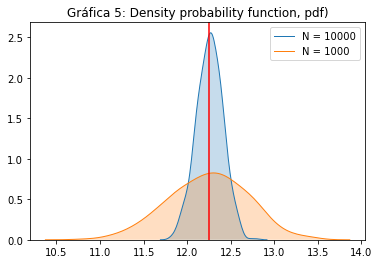

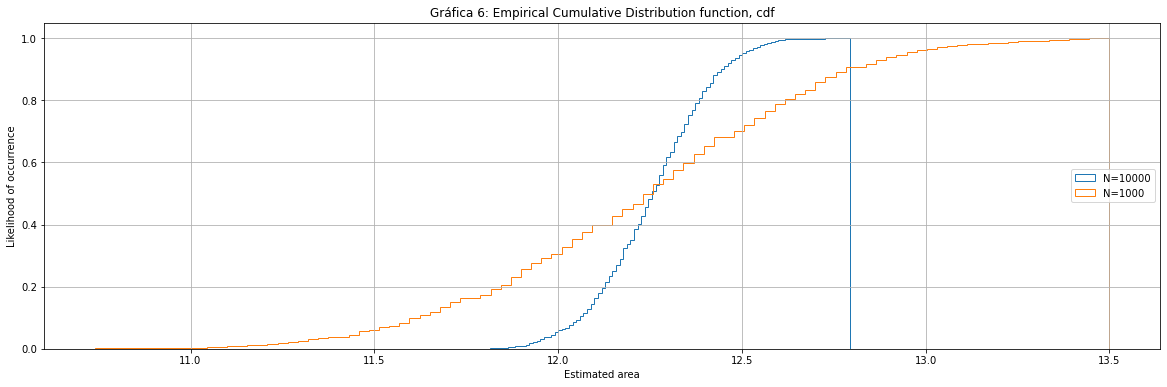

In [10]:
sns.distplot(
    simul,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 1},
    label=f"N = {N}",
)
sns.distplot(
    simul2,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 1},
    label=f"N = {N2}",
)

plt.axvline(int_num[0], color="red")
plt.title("Gráfica 5: Density probability function, pdf)")

# cdf-empirica  (matplot)
plt.figure(figsize=(20, 6))
plt.hist(
    simul, bins=100, density=True, histtype="step", cumulative=True, label="N=10000"
)
plt.hist(
    simul2, bins=100, density=True, histtype="step", cumulative=True, label="N=1000"
)
plt.grid(True)
plt.legend(loc="right")
plt.title("Gráfica 6: Empirical Cumulative Distribution function, cdf")
plt.xlabel("Estimated area")
plt.ylabel("Likelihood of occurrence")

plt.show()

## Algoritmo basado en medias

### Introducción

En el capítulo anterior vimos que dada una variable aleatoria $X$ con p.d.f conocida $f(x)$, el valor esperado de la v.a Y=$h(X)$ para una transformación continua $h(\cdot)$ se define como
\begin{equation}
\mu =  E\left[ Y \right] = E \left[ h(x) \right] = \int_{\Omega} h(x) \, f(x) \, dx
\label{y}
\end{equation}
donde $\Omega$ es el dominio de $f(x)$.

Además sabemos, por la ley de los grandes números, que la media muestral  $S_n = \frac{1}{n} \sum_{i=1}^n X_i$, donde $\{ X_1, X_1, \cdots , X_n \}$ es una muestra de $X$, es un estimador puntual no sesgado del valor esperado de $X$. 

¿Cómo estimar el valor esperado de $h(\cdot)$, eq. (\ref{y})? Emplearemos la misma metodología: extraemos una muestra de la distribución de $X$ y construímos un estimador evaluando la función $h( \cdot)$ para cada uno de los valores de la muestra y promediando
$$
\widehat{\mu} = \frac{1}{n} \sum_{i=1}^{n} h \left( X_i \right)\label{eq:estimador}
$$

Por el Teorema central del límite, el intervalo de confianza del estimador (\ref{eq:estimador}) es

$$
\text{Error} \, = 2 \, z_{\alpha / 2} \frac{\sigma_Y}{\sqrt{n}}
$$

donde $\sigma_Y^2$ representa la varianza de la v.a $Y=h(X)$. Como estimación de $\sigma_Y^2$ podemos utilizar la varianza muestral $s_Y^2$ que en este caso será
$$
s_Y^2(n) = \frac{1}{n-1} \sum_{i=1}^n \left( h(X_i) - \widehat{\mu} \right)^2
$$


<div class="qst">

Calcular la integral $\int_0^1 \left(1 - X^2 \right)^{1/2} dx = \frac{\pi}{4}$.

*Solución 1:*

Este problema es equivalente a calcular el valor esperado de la transformación $Y=h(X)$ para $h(X) = \left(1 - X^2 \right)^{1/2}$ cuando la v.a $X$ se distribuye uniformemente en el intervalo $[0,1]$. Recordad que la p.d.f de un v.a  $X\sim U(0,1)$ es

$$ f(x)=\begin{cases}
    1 & 0 \leqslant x \leqslant 1  \\ 
    0 &\text{otherwise}\end{cases}.
$$


*Algoritmo:*

**sample:** $u_1, u_2, \cdots , u_n \sim \mathcal{U}(0,1)$

 **return** $S_n = \frac{1}{n}\sum_{i=1}^{n} h(u_{i})$

*Solución 2:*

Utilizar el algoritmo de aceptación y rechazo. Compara los resultados con los proporcionados por ambos algoritmos analizando los histogramas (varianzas) de las simulaciones.



 **Comparación rendimiento algoritmos**
 
Hemos visto dos algoritmos de Monte Carlo diferentes para integrar una función $h(X)$: uno basado en medias y otro el de aceptación/rechazo. En ambos, como consecuencia del Teorema central del límite, el error disminuye como $O\left( \frac{1}{\sqrt{n}} \right)$. Sin embargo las varianzas de ambos algoritmos son diferentes ya los estimadores utilizan variables aleatorias diferentes. El algoritmo de aceptación / rechazo asigna a cada punto del espacio una variable de Bernoulli (el punto tiene valor uno o cero). Por tanto la varianza su estimador dependerá de la varianza de un v.a de Bernuoilli $\sigma_B^2$. El algoritmo de medias se constuye utilizando la v.a $Y=h(X$): su varianza será $\sigma_Y^2$.  Nos preguntamos, para un valor del error $\delta$ ¿Cúal de los dos necesitará una muestra menor? El de menor varianza  

$$
n \sim \left(  \frac{ z_{\alpha / 2 } \,  \sigma}{\delta} \right)^2
$$
donde $\sigma$ será la dispersión de la variable que utilice el algoritmo.

 Es fácil demostrar que en general, el algoritmo basado en medias tendrá una menor varianza que el de aceptación / rechazo (Neal 1993).


</div>


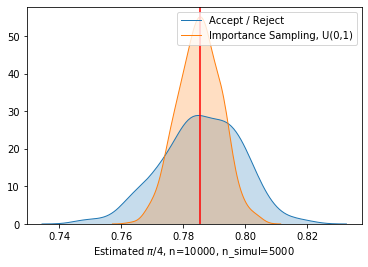

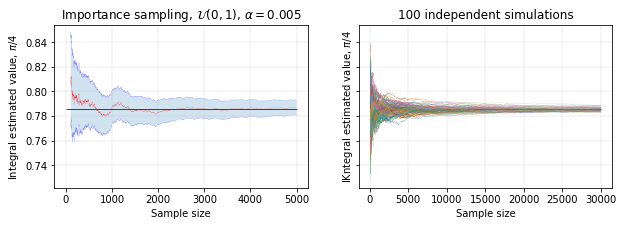

In [7]:
# ----(A) Comparación aceptación rechazo / Medias

np.random.seed(123)  # semilla para reproducibilidad

rec_x = [0, 1]
rec_y = [0, 1]
a = rec_x[0]
b = rec_x[1]
n = 1000
nsimul = 500

# función a integrar
g = lambda x: np.sqrt((1 - x * x))

# Simulación aceptación / rechazo
simul_ar = simula_integral_mc(nsimul, rec_x, rec_y, n, g)

# Integración por medias
estad_is = np.zeros(nsimul)

for i in np.arange(nsimul):
    sample = scipy.stats.uniform.rvs(loc=a, scale=b - a, size=n)
    estad_is[i] = np.mean(g(sample), dtype=np.float64)


# ------ Plot results
plt.figure()

sns.distplot(
    simul_ar,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 1},
    label="Accept / Reject",
)
sns.distplot(
    estad_is,
    hist=False,
    kde=True,
    kde_kws={"shade": True, "linewidth": 1},
    label="Importance Sampling, U(0,1)",
)
plt.axvline(np.pi / 4, color="red")
plt.xlabel(r"Estimated $\pi/4$, n=10000, n_simul=5000")
plt.show()


# -----( B) Analisis Medias, una única simulación independiente. Varios tamaños

np.random.seed(123)  # semilla para reproducibilidad
n = 5000

alpha = 0.05

# Integración por medias (Importance sampling)
x = scipy.stats.uniform.rvs(loc=a, scale=b - a, size=n)
y = g(x)
r1 = resultados(x=x, y=y, n=n, alpha=alpha)

# --- (C) Muchas simulaciones  (nsimul)
np.random.seed(123)
n = 30000
nsimul = 100

# simulation results
r_all = np.zeros((n, nsimul))

sample_uniform = scipy.stats.uniform.rvs(loc=a, scale=b - a, size=n * nsimul)
sample_uniform = sample_uniform.reshape((nsimul, n))

for simul in np.arange(nsimul):
    x = sample_uniform[simul, :]
    y = g(x)
    r = resultados(x=x, y=y, alpha=alpha, n=n)
    r_all[:, simul] = r["media"]

##### Plot (B) y (C)
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# ---- Plot (B)
desde = 100
ax[0].plot(r1["size"][desde:], r1["media"][desde:], c="red", linestyle="dotted", lw=0.3)
ax[0].plot(r1["size"][desde:], r1["ci_inf"][desde:], c="blue", alpha=0.4, lw=0.2)
ax[0].plot(r1["size"][desde:], r1["ci_sup"][desde:], c="blue", alpha=0.4, lw=0.2)

ax[0].fill_between(
    r1["size"][desde:], r1["ci_inf"][desde:], r1["ci_sup"][desde:], alpha=0.2
)

ax[0].hlines(np.pi / 4.0, 0, r1["size"][-1], lw=0.7)
ax[0].set_xlabel("Sample size")
ax[0].set_ylabel(r"Integral estimated value, $\pi/4$")
ax[0].set_title(r"Importance sampling, $\mathcal{U}(0,1)$, $\alpha = 0.005$")
ax[0].grid(lw=0.2)

# Plot (c)
xx = np.arange(1, n + 1)
desde = 100
ax[1].hlines(np.pi / 4.0, desde, xx[-1], colors="red", linewidth=1)
ax[1].plot(xx[desde:], r_all[desde:, :], linewidth=0.2, alpha=0.4)
ax[1].set_ylabel(r"IKntegral estimated value, $\pi/4$")
ax[1].set_xlabel("Sample size")
ax[1].set_title(f"{nsimul} independent simulations")
ax[1].grid(lw=0.2)

plt.show()

<div class="qst">

Estimar la integral  $\int_0^1 \left( \cos(50 x) + \sin(20 x) \right)^2 \  dx$ por Monte Carlo. Analice la convergencia de la estimación en función del tamaño de la muestra y proporcione un intervalo de confianza. 

</div>

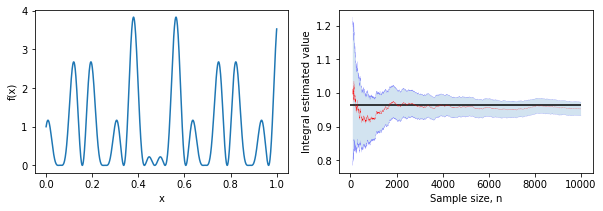

In [8]:
np.random.seed(124)  # semilla para reproducibilidad

# sample size
n = 10000

# confidence interval
alpha = 0.05

# function to integrate
g = lambda x: (np.cos(50 * x) + np.sin(20 * x)) ** 2

# range
a, b = 0, 1

x = scipy.stats.uniform.rvs(loc=a, scale=b - a, size=n)
y = g(x)
r = resultados(x=x, y=y, n=n, alpha=alpha)

# integración numerica
i_numeric = integrate.quad(g, 0, 1)[0]


fig, ax = plt.subplots(1, 2, figsize=(10, 3))

desde = 100
xx = np.linspace(a, b, 1000)
ax[0].plot(xx, g(xx))

ax[1].plot(r["size"][desde:], r["media"][desde:], c="red", linestyle="dotted", lw=0.3)
ax[1].plot(r["size"][desde:], r["ci_inf"][desde:], c="blue", alpha=0.4, lw=0.2)
ax[1].plot(r["size"][desde:], r["ci_sup"][desde:], c="blue", alpha=0.4, lw=0.2)

ax[1].fill_between(
    r["size"][desde:], r["ci_inf"][desde:], r["ci_sup"][desde:], alpha=0.2
)
ax[1].hlines(i_numeric, 0, n)


ax[0].set_xlabel("x")
ax[0].set_ylabel("f(x)")
ax[1].set_xlabel("Sample size, n")
ax[1].set_ylabel("Integral estimated value")

plt.show()


Suponed que queremos evaluar la integral en un intervalo $[a, b]$ cualquiera, no necesariamente el intervalo $[0, 1]$, 
$
I = \int_a^b g(x) \, dx.
$
Si multiplicamos y dividimos el integrando por $(b-a)$ la integral no varía. Podemos estimar $I$ utilizando una variable aleatoria uniforme $X \sim \mathcal{U}(a,b)$
$$
I =  \int_a^b (b-a) \  g(x)  \frac{1}{(b-a)} dx =  \int_a^b h(x) f(x) \, dx
$$
siendo $h(x) = (b-a) g(x)$  y donde hemos tenido en cuenta que la p.d.f de $X \sim \mathcal{U}(a,b)$
$$ f(x)=\begin{cases}\frac{1}{b-a} & a \leqslant x \leqslant b\\ 0 &\text{otherwise}\end{cases}.$$


*Algoritmo:*

 **sample:** $u_1, u_2, \cdots , u_n \sim \mathcal{U}(a,b)$

 **return** $S_n = \frac{1}{n}\sum_{i=1}^{n} (b-a) \ g(u_{i})$


### Muestreo por importancia

La idea anterior podemos extenderla para el cálculo de la integral de cualquier función continua $g(x) > 0$.

Supongamos que queremos calcular la integral
$
I = \int_{\Omega} g(x) dx
$
en una región $\Omega$.
Si multiplicamos y dividimos el integrando por una función $f(x)$ la integral no varía. 
Además si $f(x)$ es la p.d.f. de una v.a $X$ con el mismo dominio $\Omega$ que la integral
$$
I = \int_{\Omega} \frac{g(x)}{f(x)} f(x) \,  dx =  \int_{\Omega} h(x) f(x) \, dx
$$
siendo $h(x) = \frac{g(x)}{f(x)}$ podemos estimar la integral a partir de una muestra de $X$.

A la distribución $f(x)$ se le denomina *función de  importancia*. En estas condiciones nuestro algoritmo se reduciría a extraer una muestra de la variable aleatoría $X$, evaluar $h (\cdot)$ para cada punto de la muestra y hallar el promedio $S_n$

1. **sample:** $x_1, x_2, \cdots , x_n \sim \mathcal{F(\cdot)}$ 
2. **for** $i$  **in** $[1, 2,  \cdots ,n]$ :
     * $ y_i = h(x_i) = \frac{g \left( x_i \right)}{f \left( x_i \right)}$
3. **return** ${S_n} = \frac{1}{n}\sum_{i=1}^{i=n} y_{i}$

El error del estimador $S_n$ dependerá del tamaño de la muestra $n$ y de la varianza de la v.a $Y$

<div class="qst">

Estimar el valor de la integral utilizando como función de importancia primero una distribución uniforme $U(0, 10)$ y después una $N(5, 1)$
$$
I = \int_0^{10} e^{-2  \left| x - 5 \right|} \, dx
$$

</div>

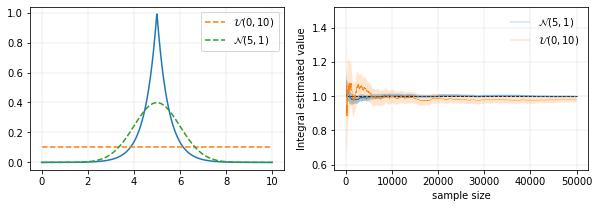

In [10]:
np.random.seed(124)  # semilla para reproducibilidad
n = 50000

# Parametros de las distribuciones
a, b = (0, 10)
mu, sigma = (5, 1)
alpha = 0.05

# funcion a integrar
g = lambda x: np.exp(-2 * np.abs(x - 5))

# Cociente g(x) / f(x)
def h(x, g, f, loc, scale):
    return g(x) / f(x, loc=loc, scale=scale)


# important function: normal
x = scipy.stats.norm.rvs(loc=mu, scale=sigma, size=n)
y = h(x=x, g=g, f=scipy.stats.norm.pdf, loc=mu, scale=sigma)
r_norm = resultados(x=x, y=y, n=n, alpha=alpha)

# Important function: uniform distribution
x = scipy.stats.uniform.rvs(loc=a, scale=b - a, size=n)
y = h(x=x, g=g, f=scipy.stats.uniform.pdf, loc=a, scale=b - a)
r_uniform = resultados(x=x, y=y, n=n, alpha=alpha)


# ----------- Plot

desde = 100
distribution = [r"$\mathcal{U}(0, 10)$", r"$\mathcal{N}(5, 1)$"]
x = np.linspace(a, b, 1000)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(x, g(x))
ax[0].plot(
    x,
    scipy.stats.uniform.pdf(x, loc=a, scale=b - a),
    linestyle="--",
    label=distribution[0],
)
ax[0].plot(x, scipy.stats.norm.pdf(x, loc=mu), linestyle="--", label=distribution[1])
ax[0].legend(loc="best")
ax[0].grid(lw=0.2)


ax[1].plot(
    r_norm["size"][desde:], r_norm["media"][desde:], lw=0.3, label=(distribution[1])
)

ax[1].fill_between(
    r_norm["size"][desde:],
    r_norm["ci_inf"][desde:],
    r_norm["ci_sup"][desde:],
    alpha=0.4,
)
ax[1].hlines(1, 0, n, linestyles="dashed", lw=0.8)

ax[1].plot(
    r_uniform["size"][desde:],
    r_uniform["media"][desde:],
    lw=0.3,
    label=(distribution[0]),
)
ax[1].fill_between(
    r_uniform["size"][desde:],
    r_uniform["ci_inf"][desde:],
    r_uniform["ci_sup"][desde:],
    alpha=0.2,
)

ax[1].set_xlabel("sample size")
ax[1].set_ylabel("Integral estimated value")
ax[1].legend(loc="best", frameon=False)
ax[1].grid(lw=0.2)


plt.show()

<div class="qst">

 Suponed que desconocemos la c.d.f. de una v.a  $\mathcal{N}(0, 1)$.  Aproximar por Monte Carlo el área bajo la p.d.f en el intervalo $[-50, 50]$. Esta cantidad será extremadamente cercana a 1, "de hecho" es 1.   Este ejercicio es muy ilustrativo aunque su interés sea puramente académico. 

 Utilizaremos una serie de funciones de muestreo de importancia para ilustrar el método: 
* una densidad uniforme $\mathcal{U}(-50, 50)$, 
* una densidad Cauchy truncada en el intervalo $[-50, 50]$ 
* una distribución $t$ de 30 grados de libertad truncada en el mismo intervalo. 

La figura muestra las tres funciones de muestreo como una curva punteada junto a la curva normal. Debajo de cada uno de estas se representa el histograma realizado con 5.000 estimaciones de Monte Carlo (cada estimador utiliza una muestra de tamaño n = 1000). Como se observa de la progresión de (a) a (c), *la estimación de la integral tiene una menor varianza cuando la función utilizada en el muestreo de importancia se halla más próxima a la densidad normal* (Nota: la característica importante es que la *forma* de la curva sea *similar*. Obviamente $g(x)$ y $f(x)$, en general, no tendrán la misma altura). 

**¿Por que?** Fíjate en la estimación realizada utilizando la distribución uniforme. Los *puntos* $x_i$ de la muestra de la v.a $X$ que forman la muestra se distribuyen uniformemente en el intervalo [-50, 50]. Esto implica que la mayoría de ellos no contribuirán al valor de la integral: la distribución normal *cae* muy rápido según nos alejamos de su valor medio. Tan solo unos cuantos puntos de la muestra, aquellos que estén en el entorno de 0, contribuirán significativamente al valor de la integral. Sin embargo en estas condiciones la varianza será muy grande. ¿Qué intentamos con el **muestreo con importancia**? Reducir el número de puntos de la muestra que no contribuyan a la integral *eligiendo una muestra **importante** en el sentido que la mayoría de sus puntos se localicen en el entorno del pico*.

</div>

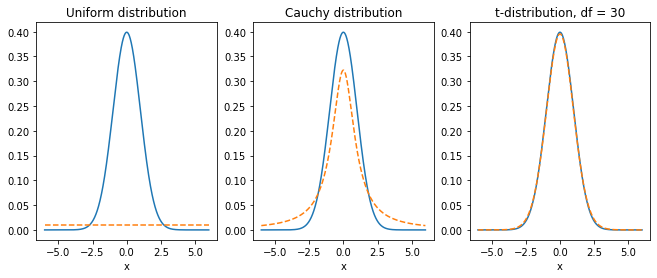

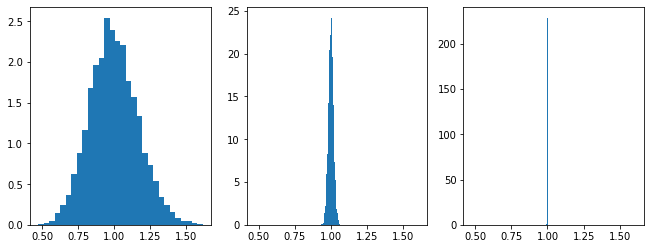

In [10]:
########## importance sampling ######
np.random.seed(123)  # semilla para reproducibilidad

# Number Monte Carlo simulations
n_mc = 5000
# Iteration in each simulation
n = 1000

x = np.linspace(-6, 6, 1000)
y_normal = scipy.stats.norm.pdf(x)

# array de resltados de los estimadores
est = np.zeros((n_mc, 3))

# ------ uniform
a = -50.0
b = 50.0
loc = a
scale = b - a
p_unif = 1 / scale

# normalization truncated Cauchy
nor_cauchy = scipy.stats.cauchy.cdf(50) - scipy.stats.cauchy.cdf(-50)
# normalization t-distribution, df=30
nor_t = scipy.stats.t.cdf(x=50, df=30) - scipy.stats.t.cdf(x=-50, df=30)

for i in np.arange(0, n_mc):
    # --------uniform
    s_unif = scipy.stats.uniform.rvs(loc=loc, scale=scale, size=n)
    ratio_unif = scipy.stats.norm.pdf(s_unif) / p_unif
    est[i, 0] = sum(ratio_unif) / len(ratio_unif)

    # -----Cauchy en el intervalo [-50, 50]
    t = scipy.stats.cauchy.rvs(size=n)
    s_cauchy = t[np.logical_and(t > -50, t < 50)]
    ratio_cauchy = (
        scipy.stats.norm.pdf(s_cauchy) * nor_cauchy / scipy.stats.cauchy.pdf(s_cauchy)
    )
    est[i, 1] = sum(ratio_cauchy) / len(ratio_cauchy)

    # ------ Truncated t-distribution , df=30
    t = scipy.stats.t.rvs(df=30, size=n)
    s_t = t[np.logical_and(t > -50, t < 50)]
    ratio_t = scipy.stats.norm.pdf(s_t) * nor_t / scipy.stats.t.pdf(s_t, df=30)
    est[i, 2] = sum(ratio_t) / len(ratio_t)

# ---------------- PLOT
# (1) Distribution
fig, ax = plt.subplots(1, 3, figsize=(11, 4))

# Uniform
ax[0].plot(x, y_normal, label="Normal")
y_unif = np.repeat(p_unif, len(x))
ax[0].plot(x, y_unif, linestyle="--", label="U(-50, 50)")
ax[0].set_xlabel("x")
ax[0].set_title("Uniform distribution")

# Cauchy en el intervalo [-50, 50]
nor_cauchy = scipy.stats.cauchy.cdf(50) - scipy.stats.cauchy.cdf(-50)
y_cauchy = scipy.stats.cauchy.pdf(x) / nor_cauchy

ax[1].plot(x, y_normal, label="Normal")
ax[1].plot(x, y_cauchy, linestyle="--", label="Truncated Cauchy")
ax[1].set_xlabel("x")
ax[1].set_title("Cauchy distribution")

# t-distribution, 30 grados de libertad,  intervalo [-50, 50]
nor_t = scipy.stats.t.cdf(x=50, df=30) - scipy.stats.t.cdf(x=-50, df=30)
y_t = scipy.stats.t.pdf(x, df=30) / nor_t

ax[2].plot(x, y_normal, label="Normal")
ax[2].plot(x, y_t, linestyle="--", label="t-distribution, 30 df")
ax[2].set_xlabel("x")
ax[2].set_title("t-distribution, df = 30")

plt.show()

# (2) Histogram
fig, ax = plt.subplots(1, 3, figsize=(11, 4), sharex=True)

ax[0].hist(est[:, 0], bins=30, density=True)
ax[1].hist(est[:, 1], bins=30, density=True)
ax[2].hist(est[:, 2], density=True)

plt.show()

<div class="qst">

Un error común del muestreo por importancia consiste en despreciar la contribución de las colas de las distribuciones. 
Aunque la función de importancia $f(x)$ pueda tener aproximadamente la misma forma que $g(x)$, surgirán dificultades serias si $f(x)$ disminuye más rápidamente que $g(x)$ en las colas. En tal caso, aunque es improbable que aparezca un valor $x_i$ perteneciente a la cola lejana de $f(x)$, $x_i$ es a fin de cuentas un evento raro, si apareciese entonces el estimador de Monte Carlo se verá seriamente afectado por el valor del cociente  $\frac{g(x)}{f(x)}$ evaluado en $x_i$.  
En estas circunstancias el ratio $\frac{g(x_i)}{f(x_i)}$ puede ser hasta varios órdenes de magnitud mayor que los valores típicos de $\frac{g(X)}{f(X)}$. 

Es importante darse cuenta que en el muestreo por importancia *no solo se  sobre-muestrean aquellas zonas que mayor contribuyen al valor del estimador sino que además se **ponderá su contribución al estimador** por medio del cociente $1/f(x)$*.  

La siguiente figura muestra el histograma de 5000 estimaciones de Monte Carlo del área entre -50 y 50 de una distribución de Cauchy (truncada en -50 y 50 y renormalizada de modo que el área exacta sea 1) cuando se utiliza como
función de importancia la densidad normal estándar (la cual, obviamente, decrece en las colas mucho más rápidamente que la distribución de Cauchy). Nótese en particular que alrededor de 43 de las 5,000 estimaciones de Monte Carlo  para el área de la función de Cauchy truncada fueron mayores que 1.5, en este ejemplo algunas incluso fue superior a 53!!.

</div>

numero de simulaciones cuyo estimador excede 1.5: 43
[ 2.306  2.465  1.686  1.638  2.269  1.784  1.561  3.783  1.891  2.623
  5.354  2.761  2.385  2.083  4.719  7.287  1.707  1.553  1.559 53.132
  3.481  2.113  1.726 29.119  2.241  1.504  1.9    1.66   2.687  2.276
  1.658  6.449 17.664  1.986  1.875  3.517  1.518  1.873  3.589  1.566
  2.013  1.613  1.539]


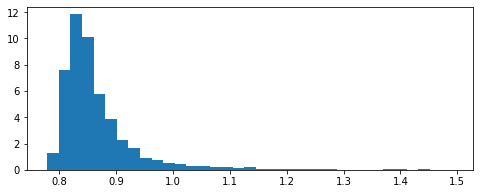

In [4]:
np.random.seed(123)  # semilla para reproducibilidad

# Number Monte Carlo simulations
n_mc = 5000
# Iteration in each simulation
n = 1000

# Output
estd = np.zeros(n_mc)

# normalization truncated Cauchy
nor_cauchy = scipy.stats.cauchy.cdf(50) - scipy.stats.cauchy.cdf(-50)
nor_nor = scipy.stats.norm.cdf(50) - scipy.stats.norm.cdf(-50)

for i in np.arange(0, n_mc):
    # sample from the important distribution
    t = scipy.stats.norm.rvs(size=n)
    s_norm = t[np.logical_and(t > -50, t < 50)]

    # Eval h(x)
    ratio_norm = (scipy.stats.cauchy.pdf(s_norm) / nor_cauchy) / scipy.stats.norm.pdf(
        s_norm
    )
    estd[i] = sum(ratio_norm) / len(ratio_norm)


# Analisis de resultados
# (1) Establece limite al valor del estimador
limite = 1.5
print(
    f"numero de simulaciones cuyo estimador excede {limite}: {len( estd[estd > limite] )}"
)
# imprime los que superan el valor del limite
np.set_printoptions(precision=3)
print(estd[estd > limite])

# (2) Plot:
# Histograma de las estimaciones que no superan el limite
fig, ax = plt.subplots(1, figsize=(8, 3), sharex=True)
ax.hist(estd[estd < limite], bins=35, density=True)

plt.show()

<div class="qst">

Suponga la v.a $X \sim \mathcal{N}(0,1)$ Estime mediente métodos de Monte Carlo la $P(X>4.5)$ suponiendo que desconocemos su c.d.f.
$$
I = \frac{1}{2\sqrt{\pi}} \, \int_{4.5}^{\infty}  e^{- x² /2  } \,dx
$$

 *Solución 1:*

Podríamos definir la función $f(x)$ con el dominio $[4.5, \infty]$ 
$$
f(x) =
\begin{cases}
\frac{1}{2\sqrt{\pi}}  e^{- x^2 / 2 } & 4.5 \leqslant x  \\
              0 &\text{otherwise}
\end{cases}
$$

y estimar la integral $I = \int_{4.5}^{\infty} g(x) \, dx$ utilizando como función de importancia la distribución normal  $\mathcal{N}(0,1)$

El problema con esta estrategia es que dado que la $P(X>4.5)$ es $\sim 10^{-6}$, estamos interesados en eventos muy raros, la probabilidad de obtener valores de la muestra mayores de 4.5 (esto es la probabilidad de $g(X) \neq$ 0) 
requeriría una gran cantidad de iteraciones para obtener una respuesta estable. 

 *Solución 2*:

Si utilizamos otra *función de importancia*,
podemos mejorar nuestra precisión y reducir el número de iteraciones
en varios órdenes de magnitud.
Por ejemplo, si consideramos una distribución con soporte restringido al intervalo $[4.5, \infty]$,
la variación adicional e innecesaria del estimador de Monte Carlo debido a la presencia de ceros cuando $x <4.5$ desaparece. 

Una elección natural es elegir como función $f(x)$ la distribución exponencial $\mathcal{Exp}(1)$ truncada en el intervalo $[4.5, \infty]$
$$
f(x) = \frac{e^{-x}}{\int_{4.5}^{\infty} e^{-x} \, dx} = e^{x-4.5}
$$

</div>

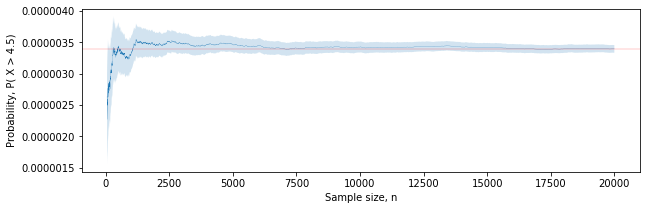

In [12]:
np.random.seed(123)  # semilla para reproducibilidad

n = 20000
d = 4.5

# confidence interval
alpha = 0.05


def h(x, d):
    return scipy.stats.norm.pdf(x) / scipy.stats.expon.pdf(x - d)


# Important function
x = scipy.stats.expon.rvs(size=n) + d
y = h(x, d=d)

r = resultados(x=x, y=y, n=n, alpha=alpha)

# ---- plot the probability -----

desde = 50
fig, ax = plt.subplots(1, figsize=(10, 3))

xx = np.arange(start=1, stop=len(x) + 1, step=1)
ax.plot(r["size"][desde:], r["media"][desde:], lw=0.2)

ax.fill_between(r["size"][desde:], r["ci_inf"][desde:], r["ci_sup"][desde:], alpha=0.2)
ax.axhline(1.0 - scipy.stats.norm.cdf(d), color="r", linestyle="-", lw=0.2)
ax.set_xlabel("Sample size, n")
ax.set_ylabel("Probability, P( X > 4.5)")

plt.show()

#### Características de una función de importancia apropiada

Una buena función de importancia debe tener las siguientes características:
* $f(X) > 0$ cuando $g(X) \neq 0$
* Para reducir la varianza $f(X)$ debería ser muy próxima a $|g(X)|$. Debemos intentar que $f(x) \propto |g(x)|$. En la práctica esto no es posible ya que la constante de proporcionalidad sería el valor de la integral buscada!!
* Debe ser sencillo (poco costoso) obtener una muestra de $f(x)$
* Debe ser sencillo evaluar la p.d.f de f(x) para cualquier valor de la muestra.
    

#### Aplicación del muestreo por importancia para estimación del valor esperado de una transformación

En la sección 3.1 vimos como estimar el valor esperado de una transformación continua $h(X)$ de una v.a  $X$ cuya p.d.f es $f(x)$ 
\begin{equation}
\mu =  E \left[ h(x) \right] = \int_{\Omega} h(x) \, f(x) \, dx
\label{y1}
\end{equation}
Para ello extraíamos una muestra de la distribución de $X$ y construíamos un estimador evaluando $h(X)$ para cada uno de los valores de la muestra y promediando
$$
\widehat{\mu} = \frac{1}{n} \sum_{i=1}^{n} h \left( X_i \right)
\label{eq:estimador1}
$$



Sin embargo pudiese ocurrir que en determinadas ocasiones no sea posible, o sea muy poco eficiente, obtener una muestra de $X$. En estas condiciones podemos utilizar una función de importancia $q(x)$ para estimar (\ref{y1}):

\begin{equation}
\mu = E \left[ h(x) \right] = \int_{\Omega} h(x) \, f(x) \, dx = 
\int_{\Omega} \frac{ h(x) f(x) }{q(x)} q(x) \, dx = 
\int_{\Omega} h'(x) \, q(x) \, dx
\label{y2}
\end{equation}
    
siendo 
$ h'(x) =  \frac{ h(x) f(x) }{q(x)}$
y estimar la integral anterior a partir de una muestra de una v.a de p.d.f $X \sim q(X)$.

<div class="qst">

*Es posible estimar el valor esperado de una función $h(\cdot)$ de una v.a $X$ de la que conocemos su p.d.f pero de la que **no** tenemos una muestra utilizando una muestra de otra variable aleatoria.*

</div>

<div class="qst">

Estimar el valor esperado del segundo momento de la variable aleatoria cuya p.d.f es 
$$
f(x) = \frac{1}{2}  e^{-|x|}
$$

 *Solución:*

Debemos estimar
$$
I = \int_{-\infty}^{\infty} x^2  \frac{1}{2}  e^{-|x|} \, dx = 2
$$
Para ello podemos utilizar una muestra $f(x)$ como vimos en la sección 3.1. 
Sin embargo, si carecemos de un algoritmo para obtener una muestra de esta distribución (o no es eficiente) podemos utilizar como función de importancia $q(x)$ otra función densidad de probabilidad. 
Para este ejemplo una posible $\sim \mathcal{N}(0, 4)$

Teniendo en cuenta que $\frac{1}{2 \sqrt{2 \pi}} e^{-x² / 4}$ es la p.d.f de una distribución $\mathcal{N}(0, 4)$, estimaremos el valor esperado
$$
\hat{I} = E \left[  X^2 \frac{   \frac{1}{2}  e^{-|X|} }{ \frac{1}{2 \sqrt{2 \pi}} e^{-X^2 / 4} }
\right]
$$
utilizando una muestra $\{ X_1, X_2, \ldots, X_n \}$ de $\mathcal{N}(0, 4)$.

</div>

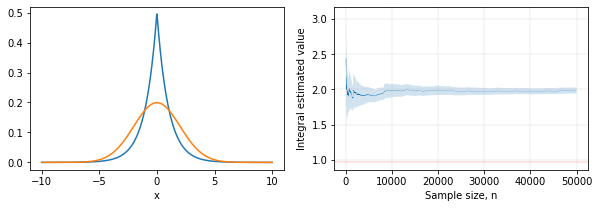

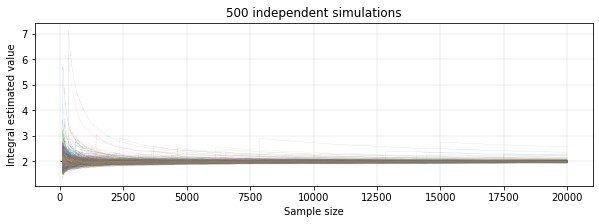

In [9]:
np.random.seed(123)
n = 50000
alpha = 0.005
sigma2 = 4


f = lambda x: 1.0 / 2.0 * np.exp(-np.abs(x))


def h(x, sigma2):
    y = x**2 * 1.0 / 2.0 * np.exp(-np.abs(x))
    return y / scipy.stats.norm.pdf(x, scale=np.sqrt(sigma2))


# ----(A)  Algoritmo de Monte Carlo 1 simulacion independiente
np.random.seed(123)  # semilla para reproducibilidad
sample = scipy.stats.norm.rvs(scale=np.sqrt(sigma2), size=n)
y = h(sample, sigma2)
r = resultados(x=sample, y=y, alpha=alpha, n=n)


# Plot
desde = 100
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

x = np.linspace(-10, 10, 1000)
ax[0].plot(x, f(x), x, scipy.stats.norm.pdf(x, scale=np.sqrt(sigma2)))
ax[0].set_xlabel("x")

ax[1].plot(r["size"][desde:], r["media"][desde:], lw=0.2)

ax[1].fill_between(
    r["size"][desde:], r["ci_inf"][desde:], r["ci_sup"][desde:], alpha=0.2
)

ax[1].axhline(i_numeric, 0, r["size"][desde:][-1], color="r", linestyle="-", lw=0.2)
ax[1].set_xlabel("Sample size, n")
ax[1].set_ylabel("Integral estimated value")
ax[1].grid(lw=0.2)

plt.show()

# --- (B) Muchas simulaciones independientes (nsimul)
np.random.seed(123)
n = 20000
nsimul = 500

# simulation results
r_all = np.zeros((n, nsimul))

sample_nsimul = scipy.stats.norm.rvs(scale=np.sqrt(sigma2), size=n * nsimul)
sample_nsimul = sample_nsimul.reshape((nsimul, n))

for simul in np.arange(nsimul):
    x = sample_nsimul[simul, :]
    y = h(x, sigma2)
    r = resultados(x=x, y=y, alpha=alpha, n=n)
    r_all[:, simul] = r["media"]


fig, ax = plt.subplots(1, figsize=(10, 3))
xx = np.arange(1, (n + 1))
ax.plot(xx[desde:], r_all[desde:, :], linewidth=0.2, alpha=0.4)
ax.hlines(2, 0, xx[-1], lw=0.9)
ax.set_ylabel(r"Integral estimated value")
ax.set_xlabel("Sample size")
ax.set_title(f"{nsimul} independent simulations")
ax.grid(lw=0.2)

plt.show()

## Comparación Monte Carlo frente a integración numérica

Si bien la integración de un volumen físico generalmente se limita a tres dimensiones,hay muchos casos en ciencia e ingeniería en los que se requiere una integración de dimensiones superiores.
En los algoritmos de integración numérica la tasa de convergencia empeora con la dimensión $d$ del problema. Este efecto se conoce como *la maldición de la dimensionalidad* en la que un un método se vuelve intratable con el aumento de la dimensión del problema. Por ejemplo

* Punto medio: $O(1/N^{1/d})$
* Regla trapezoidal: $O(1/N^{2/d})$
* Simpson: $O(1/N^{4/d})$


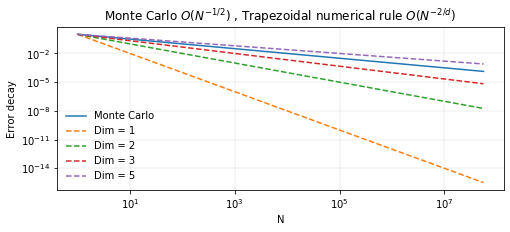

In [3]:
# Error as function of N

maxim = 45
N = 1.5 ** np.arange(maxim)

# Monte Carlo error
mc = lambda n: 1 / np.sqrt(n)

# Numerical trapezoidal rule
trapez = lambda n, s: n ** (-2 / s)

fig, ax = plt.subplots(1, figsize=(8, 3))

# Monte Carlo plot
ax.plot(N, mc(N), label="Monte Carlo")

# Trapezoidal rule plot
s = [1, 2, 3, 5]
for i in s:
    ax.plot(N, trapez(N, s=i), "--", label=f"Dim = {i}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("N")
ax.set_ylabel("Error decay")
ax.legend(loc="best", frameon=False)
texto = r"Monte Carlo $O( N^{-1/2} )$ , Trapezoidal numerical rule $O( N^{-2/d} )$"
ax.set_title(texto)
ax.grid(lw=0.2)
plt.show()

\begin{remark}

Los métodos de Monte Carlo no sufren de la maldición de la dimensionalidad.

En el siguiente ejemplo mostramos como en la varianza (convergencia) del estimador de la integral con un método de de Monte Carlo no depende de la dimensionalidad del espacio.

*Ejemplo*

Generalicemos nuestro primer ejercicio (algoritmo de aceptación / rechazo) al caso de la integración de una región $d$-dimensional. 

Cada punto en el método de Monte Carlo se representará por un vector aleatorio, $(X_1, X_2, \cdots, X_d)$. A cada punto se  asocia una variable aleatoria de Bernoulli de probabilidad $p$, siendo $p$ la pobabilidad de aceptar el punto. 
La varianza  del estimador, y por tanto el error o la convergencia, dependerá de las variables aleatorias del proceso de  Bernoulli, y por tanto de $p$ y de $n$ pero **no** de la dimensionalidad $d$ del vector aleatorio.

Debido a que la desviación estándar, $\sigma$, de la distribución binomial se escala como $N^{−1/2}$ (el número de *puntos aceptados* sigue una distribución binomial), esperamos que el 
método de aceptación / rechazo converja como $O \left( \frac{1}{N^{1/2}} \right)$ independientemente de $d$. 



\end{remark}

\begin{example}
Estimar el valor de $\pi$ utilizando el volumen de una hyperesfera para $d=2, 3, 5, 7$. Mostrar que la convergencia (error) no depende de $d$

$$ 
V_D = \frac{ \pi^{d/2} }{ \Gamma (n/2 + 1) } r^d
$$
\end{example}

## Reducción de varianza: variables antitéticas

Supongamos que queremos estimar una determinada magnitud $\theta := E\left[ h(X) \right] =  E\left[ Y \right]$ donde $h(\cdot )$ es una función dada de una v.a  $X  \sim F(X)$, por ejemplo en los ejercicios anteriores estimábamos el área de una integral en un cierto intervalo o en el modelo de colas estimábamos el tiempo de los clientes en el sistema. En los algoritmos de Monte Carlo sabemos que la varianza del estimador se comporta como $\sigma^2 / n$. ¿Cómo podemos reducir su varianza? Tenemos dos posibilidades. Aumentando el tamaño $n$ de la muestra, lo que incrementaría el tiempo de cálculo, o disminuyendo $\sigma^2$, tal y como hacíamos en la técnica del *muestreo por importancia*. En este apartado veremos otra estrategia para disminuir $\sigma^2$.

**Variables antitéticas**


A diferencia de lo hecho hasta ahora, generamos **dos** muestras diferentes del mismo tamaño $n$. Para cada una de ellas generaremos un estimador $Y_i$ con $i=1,2$. Con ambos estimadores componemos un nuevo estimador puntual
$$\tilde{\theta} = (Y_1 + Y_2) / 2$$

Si $Y_i$ e $Y_2$ son v.a IID, esto es han sido obtenidos independientemente de la misma distribución de $X$, entonces es fácil deducir que $\tilde{\theta}$ será un estimador no sesgado
$$E[\tilde{\theta}] = E\left[ Y_1 \right] = E \left[Y_2 \right]$$
¿Cuál será su varianza?
$$
\text{Var} \left( \tilde{\theta} \right) = \frac{ \text{Var}\left( Y_1  \right) +
 \text{Var}\left( Y_2  \right) +  \text{Cov}\left( Y_1, Y_2  \right) }{4}
$$
En el caso de que $Y_1$ e $Y_2$ sean independientes
$ \text{Var} \left( \tilde{\theta} \right) = \text{Var}\left( Y_1 \right) / 2$. Donde el error se ha reducido *fictíciamente* en un factor 2 ya que nuestro planteamiento es equivalente a tener una única muestra de tamaño $2n$ (cada una de las muestras es de tamaño $n$). No hemos ganado nada: la *aparente* disminución de la varianza tan solo es una consecuencia del aumento del tamaño de la muestra. 

Sin embargo, si *somos lo suficientemente astutos* y conseguimos que 
 $ \text{Cov}\left( Y_1, Y_2  \right) < 0 $ reduciríamos la varianza del estimador y por tanto su error. Para ello **necesitamos** que $Y_1$ e $Y_2$ tengan la misma distribución pero que **no** sean independientes ¿Cómo conseguirlo? Eligiendo las muestras *correlacionadas negativamente*.

Empecemos describiendo un proceso válido para una distribución $X \sim U(0,1)$ y después lo generalizaremos a cualquir otra distribución. Para ello utilizaremos el siguiente algortimo,

*Pseudo-código:*

1. **for** $i=0$ to $n$ :
    * **generate** $\mathcal{u}_i$  : 
    * **set**  $y_i = h(u_i)$ and  $\tilde{y}_i = h(1-u_i)$
    * **set**  $z_i = \frac{y_i + \tilde{y}_i }{2} $
3. **return** ${S_n} = \frac{1}{n}\sum_{i=1}^{n} z_{i}$

Se dice que dos variables aleatorias que tienen la misma distribución y correlación negativa son antitéticas. Notad como las v.a $U$ y $1-U$ son antitéticas: tienen la misma distribución  $\sim U(0, 1)$ y su correlación es $-1$. 


\begin{exercise}

Suponga la integral  $\int_0^1 \left( e^x \right)^2 \  dx$.
Estime la integral por el método de Monte Carlo *muestreo por importancia* utilizando la distribución uniforme. Compare la estimación *con y sin* el uso de variables antitéticas. 


\end{exercise}


```python
np.random.seed(123)
f = lambda x : np.exp(x)**2
i_numeric = integrate.quad (f, 0, 1)[0] 
n = 50000
n2 = int(n/2)

# -------Procedimiento Monte Carlo habitual -----
# 1. Obtención de una muestra
x = scipy.stats.uniform.rvs (size = n)
# 2. Evaluar y = f(x) para cada valor de la muestra
y = f(x)
# 3. Estimador del área
s_mc = np.mean (y)
# 4. Varianza del estimador 
s2_mc = np.var (y, ddof=1)  # estimación de la varianza de y = f(x)
sigma2_mc = s2_mc / n

# ----Procedimiento de MC utilizando variables antitéticas --
# 1. Obtención de una muestra antitética
x_2 = 1- x[0:n2]
y_2 = f(x_2) 
# 2. Media 
y_ant = 1./2. * ( y[0:n2] +  y_2 )
# 3. Estimador 
theta = np.mean(y_ant)
# 4. Varianza del estimador
s2_theta = np.var (y_ant, ddof = 1)
sigma2_theta = s2_theta / n2

# ¿La varianza del estimador es la que esperábamos?
cov = np.cov(y[0:n2], y_2, ddof=1)
y_at_teorica = (1/4) * (cov[0,0] + cov[1, 1] + 2 * cov [0,1] )
print (f"Numeric: {i_numeric:.4f}, MC: {s_mc:.4f}, Ant: {theta:.4f}" )
reducc = (sigma2_mc - sigma2_theta)/ sigma2_mc
print (f"MC: {sigma2_mc:.6f}, ANT: {sigma2_theta:.6f}, Red: {reducc :.4f}" )
print( 'Pearson corr', scipy.stats.pearsonr( y[0:n2], y_2)[0])
print("Covarianza", cov)

```

Numeric: 3.1945, MC: 3.2012, Ant: 3.1914
MC: 0.000064, ANT: 0.000007, Red: 0.8826
Pearson corr -0.8821429353909369
Covarianza [[ 3.15906893 -2.79595281]
 [-2.79595281  3.17996727]]


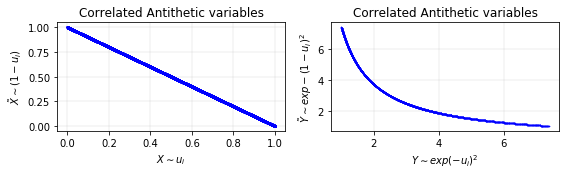

In [3]:
np.random.seed(123)

f = lambda x: np.exp(x) ** 2

i_numeric = integrate.quad(f, 0, 1)[0]

n = 50000
n2 = int(n / 2)

# ------- Procedimiento Monte Carlo habitual -----

# 1. Obtención de una muestra
x = scipy.stats.uniform.rvs(size=n)

# 2. Evaluar y = f(x) para cada valor de la muestra
y = f(x)
#  3. Estimador del área
s_mc = np.mean(y)
#  4. Varianza del estimador (error del estimador)
s2_mc = np.var(y, ddof=1)  # estimación de la varianza de nuestro estimador y = f(x)
sigma2_mc = s2_mc / n

# -------- Procedimiento de MC utilizando variables antitéticas -----

# 1. Obtención de una muestra antitética
x_2 = 1 - x[0:n2]
y_2 = f(x_2)

#  2. Media
y_ant = 1.0 / 2.0 * (y[0:n2] + y_2)

# 2. Estimador
theta = np.mean(y_ant)

# 3. Varianza del estimador
s2_theta = np.var(y_ant, ddof=1)
sigma2_theta = s2_theta / n2

# ¿La varianza del estimador es la que esperábamos?
cov = np.cov(y[0:n2], y_2, ddof=1)
y_at_teorica = (1 / 4) * (cov[0, 0] + cov[1, 1] + 2 * cov[0, 1])


print(f"Numeric: {i_numeric:.4f}, MC: {s_mc:.4f}, Ant: {theta:.4f}")
reducc = (sigma2_mc - sigma2_theta) / sigma2_mc
print(f"MC: {sigma2_mc:.6f}, ANT: {sigma2_theta:.6f}, Red: {reducc :.4f}")
print("Pearson corr", scipy.stats.pearsonr(y[0:n2], y_2)[0])

print("Covarianza", cov)

########### Plot ----

fig, ax = plt.subplots(1, 2, figsize=(9, 2))

ax[0].plot(x[0:n2], x_2, "bo", markersize=1)
ax[0].set_ylabel(r"$\tilde{X} \sim (1-u_i)$")
ax[0].set_xlabel(r"$X \sim u_i$")
ax[0].set_title("Correlated Antithetic variables")
ax[0].grid(lw=0.2)

ax[1].plot(y[0:n2], y_2, "bo", markersize=0.1)
ax[1].set_ylabel(r"$ \tilde{Y} \sim exp-(1-u_i)^2$")
ax[1].set_xlabel(r"$Y \sim exp(-u_i)^2$")
ax[1].set_title("Correlated Antithetic variables")
ax[1].grid(lw=0.2)

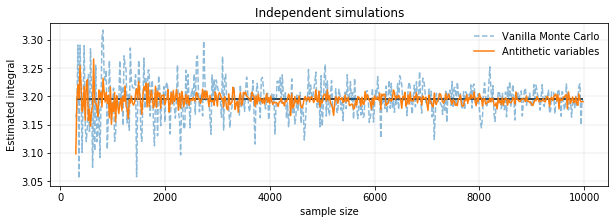

In [15]:
def est_antithetic(f, x, x_a):
    """Compare plain Monte Carlo against antithetic variables
    f: function to integrate
    x (float list): sample
    x_a (float list): antithetic sample:"""
    # MC plain
    n = len(x)
    y = f(x)
    s_mc = np.mean(y)
    s2_mc = np.var(y, ddof=1)
    sigma2_mc = s2_mc / n

    # antithetic
    n2 = int(n / 2)
    y_2 = f(x_a[0:n2])
    theta = 1.0 / 2.0 * (y[0:n2] + y_2)
    mean_theta = np.mean(theta)
    s2_theta = np.var(theta, ddof=1)
    sigma2_theta = s2_theta / n2

    return [s_mc, sigma2_mc, mean_theta, sigma2_theta]


# ---main program
np.random.seed(123)
f = lambda x: np.exp(x) ** 2
i_numeric = integrate.quad(f, 0, 1)[0]

seq = np.arange(300, 10000, 20)
r = []

for n in seq:
    x = scipy.stats.uniform.rvs(size=n)
    x_a = 1 - x
    r.append(est_antithetic(f, x, x_a))

r = np.array(r)

# --plot
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.plot(seq, r[:, 0], "--", alpha=0.5, label="Vanilla Monte Carlo")
ax.plot(seq, r[:, 2], label="Antithetic variables")
ax.hlines(i_numeric, min(seq), max(seq))
ax.set_xlabel("sample size")
ax.set_ylabel("Estimated integral")
ax.set_title("Independent simulations")
ax.legend(loc="best", frameon=False)
ax.grid(lw=0.2)

plt.show()

* ¿En que condiciones  podemos asegurar que  $ \text{Cov}\left( Y_1, Y_2  \right) < 0 $?

Suponga que  $h(\cdot )$ es una función no decreciente en el intervalo $[0, 1]$. Si $U$ es grande, próximo a 1, entonces $h(U)$ tenderá a ser grande, mientras que tanto $1-U$ como $h(1-U)$ tenderán a ser pequeños y por tanto $\text{Cov}( h(U) , h(1-U)) < 0$. 
Igualmente podemos concluir que si  $h(\cdot )$ es una función no creciente entonces $\text{Cov}( h(U) , h(1-U)) < 0$. Es decir, para que se reduzca la varianza es **condición suficiente** que 
$h(\cdot )$ sea una función monótona.

¿Cuanto se reduce la varianza del estimador cuando se utilizan variables antitéticas? Como hemos visto en la ecuación (29) depende de la magnitud de la covarianza de las variables $h(U)$ y $h(1-U)$. Al tener la covarianza unidades de medida, es mas útil expresar la varianza del estimador en función de la correlación $\rho$
$$
\text{Var}(\theta) = \frac{\sigma^2}{n} (1 + \rho) 
$$
donde $\rho = \text{Corr}\left( h(X), h(\tilde{X} \right) $ siendo $\tilde{X}$ una variable antitética de $X$. 
Al ser $-1 \leqslant \rho \leqslant 1$  obtenemos $0 \leqslant \sigma^2 (1+\rho) \leqslant 2 \sigma^2$. En el mejor de los casos, el muestreo antitético produce la respuesta exacta. En el peor de los casos, duplica la varianza. Cuando $h(\cdot)$ sea mas próxima a una función lineal en sus argumentos mas importante será la reducción de la varianza.


>**Nota:** En los ejemplos que hemos hecho hasta ahora  $h(\cdot )$ es una función que depende de una variable univariante (una sola dimensión). En el caso de que  $h(\cdot )$ fuese una función de varios argumentos, por ejemplo si estuviésemos estimando una integral de dimensión $d > 1$, una condición de suficiencia es que $h(\cdot )$ sea  monótona para cada uno de sus argumentos.

**Variables antitéticas no-uniformes: Caso general.** 

Distinguimos dos posibilidades:
   * En el caso de que la v.a $X$ sea simétrica respecto a un punto central $c$, su variable antitética $\tilde{X}$ será $\tilde{X}= 2c - X$. 
   
   Por ejemplo, si  $\{ x_0, x_1, \cdots , x_n \}$ es una muestra de la v.a $X\sim U(0,1)$ y, por tanto, simétrica respecto a $c=0.5$,  $\{ (1-x_0), (1-x_1), \cdots , (1-x_n) \}$ es una muestra de una variable antitética ya que $\tilde{X} = 2 \frac{1}{2} - X$.   O si   $X \sim N(\mu, \sigma^2)$, $\tilde{X} \sim 2\mu - X$ será su antitética. 
    
   * Cuando la función densidad de probabilidad de la v.a $X$ no sea simétrica, para hallar su antitética $\tilde{X}$, recurriremos al teorema de la función inversa (antes de seguir leyendo debes enteneder el método de la función invers que se explica en el siguiente tema).
   
 Supongamos que para obtener una muestra de de la v.a $X$ hemos utilizado el método de la función inversa. En este método una muestra  $\{ x_0, x_1, \cdots , x_n \}$ de la v.a $X \sim F(X)$ se genera a partir de una muestra $\{ u_0, u_1, \cdots , u_n \}$  de $U(0,1)$ y la inversa $F^{-1}$. Cuando la inversa de la función de distribución $F^{-1}$ sea monótona, podemos generar la v.a antitéica $\tilde{X}$ utilizando la muestra negativamente correlacionada $\{(1-u_0), (1-u_1), \cdots , (1-u_n) \}$.
  
 Por ejemplo si la muestra $X \sim E (\lambda)$ ha sido obtenida a partir de la muestra $\{ u_0, u_1, \cdots , u_n \}$ y la inversa $F^{-1}(U)$
 $$
 x_i = \frac{- \log u_i}{\lambda}
 $$ 
 su antitética será
 $$
 \tilde{x_i} = \frac{- \log (1-u_i) }{\lambda}
 $$ 

\begin{exercise}
Realice el ejercicio 2 utilizando variables antitéticas.
Discuta los resultados para diferente valores de n (realice las simulaciones independientes, esto es, sin utilizar la función 'cumsum') 
\end{exercise}

\begin{exercise}
En el ejercicio 7,  proporcione un estimador de menor varianza

\end{exercise}


MC: 3.37e-06, sigma2: 3.85e-16, Ant: 3.38e-06  sigma2: 1.65e-16 
Reduccion varianza: 57.063
Pearson corr -0.5709200160027587


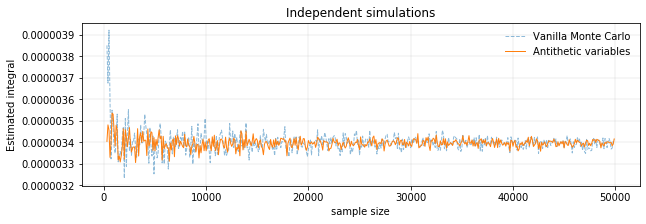

In [17]:
np.random.seed(123)  # semilla para reproducibilidad

n = 50000
d = 4.5


def h(x, d=d):
    return scipy.stats.norm.pdf(x) / scipy.stats.expon.pdf(x - d)


# Important function
sample = scipy.stats.expon.rvs(size=n)
x = sample + d
y = h(x, d=d)
s_mc = np.mean(y)
s2_mc = np.var(y, ddof=1)
sigma2_mc = s2_mc / n

# --- Antithetic variables -----
# (no eficiente, hecho por motivos docntes)
u = 1 - scipy.stats.expon.cdf(sample, loc=0, scale=1)
x_a = scipy.stats.expon.ppf(u, loc=0, scale=1) + d
n2 = int(n / 2)

y_2 = h(x_a[0:n2], d=d)

theta = 1 / 2.0 * (y[0:n2] + y_2)
theta_mean = np.mean(theta)
theta_s2 = np.var(theta, ddof=1)
theta_sigma2 = theta_s2 / n2

print(
    f"MC: {s_mc:0.2e}, sigma2: {sigma2_mc:0.2e}, Ant: {theta_mean:0.2e}  sigma2: {theta_sigma2:0.2e} "
)
reducc = (sigma2_mc - theta_sigma2) / sigma2_mc * 100
print(f"Reduccion varianza: {reducc:0.3f}")

# print('Covariance matrix', np.cov(y[0:n2] , y_2, ddof=1))
print("Pearson corr", scipy.stats.pearsonr(y[0:n2], y_2)[0])

# (b) Dependencia con n:


seq = np.arange(300, 50000, 100)
r = []

for n in seq:
    sample = scipy.stats.expon.rvs(size=n, loc=0, scale=1)
    x = sample + d
    u = 1 - scipy.stats.expon.cdf(sample, loc=0, scale=1)
    x_a = scipy.stats.expon.ppf(u, loc=0, scale=1) + d

    r.append(est_antithetic(h, x, x_a))

r = np.array(r)


# --plot
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.plot(seq, r[:, 0], "--", alpha=0.5, linewidth=1, label="Vanilla Monte Carlo")
ax.plot(seq, r[:, 2], linewidth=1, label="Antithetic variables")
# ax.hlines(i_numeric, min(seq), max(seq) )
ax.set_xlabel("sample size")
ax.set_ylabel("Estimated integral")
ax.set_title("Independent simulations")
ax.legend(loc="best", frameon=False)
ax.grid(lw=0.2)

plt.show()

## Para finalizar....


### *on-line*

En los programas utilizados en los ejercicios los datos obtenidos a partir de la simulación se han almacenado en una array y, una vez finalizada la simulación, se calcula el valor del estimador y su varianza. 

Sin embargo, a menudo es útil poder calcular media y la varianza en una sola pasada, esto es, inspeccionando cada valor obtenido en la simulación $x_ {i}$ una única vez. Por ejemplo, cuando no se dispone de suficiente espacio de almacenamiento para mantener todos los valores o cuando el coste de acceso a la memoria domina a los costes de computación. Los algoritmo *en línea*, utilizan una relación de recurrencia entre cantidades con las que se calculan las estadísticas requeridas:

Las fórmulas siguientes se pueden utilizar para actualizar la media $\widehat x_{n-1}$  y la varianza del estimador cuando se recibe un elemento adicional $x_n$:

\begin{align*}
\widehat x_n   &=  \widehat x_{n-1} + \frac{x_n - \widehat x_{n-1} }{n} \\
s^2_n &= s^2_{n-1} + \frac{ \left( x_n - \widehat x_{n-1} \right)^2 }{n}  - \frac{s^2_{n-1} }{n-1} \ \ n>1 \\
\sigma^2_n &= \sigma^2_{n-1} + 
\frac{  \left( x_n - \widehat x_{n-1} \right) \left( x_n - \widehat x_{n} \right) - \sigma^2_{n-1}  }{n}
\end{align*}  

donde $x_n$ denota un elemento adicional, $\widehat x_n$ la media muestral tras recibir el elemnto adicional, $s²$ la media muestral y $\sigma²$ la varianza del estimador. 

Este algoritmo puede ser *refinado* para evitar inestabilidades numéricas como el término $ \left( x_n - \widehat x_{n-1} \right)^2 $ (Wleford). 

### ¿y sino puedo aplicar TCL?

Fijate en la distribución de Cauchy, ¿tiene definidos los primeros momentos? 

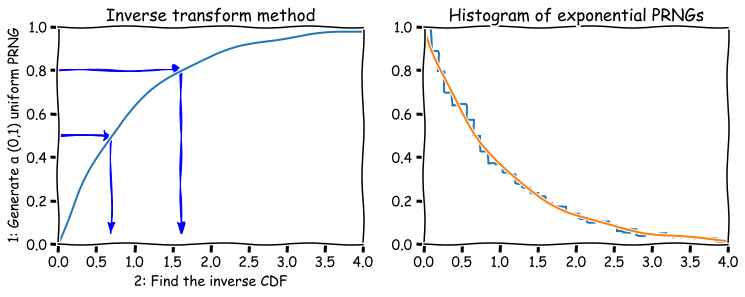